In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
labels = open('/content/gdrive/My Drive/humandetection/yolo-data/coco.names').read().strip().split('\n') 

In [4]:
weights_path = '/content/gdrive/My Drive/humandetection/yolo-data/yolov3.weights'
configuration_path = '/content/gdrive/My Drive/humandetection/yolo-data/yolov3.cfg'

probability_minimum = 0.5

threshold = 0.3


In [5]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

layers_names_all = network.getLayerNames()


In [6]:
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]

print(layers_names_output)


['yolo_82', 'yolo_94', 'yolo_106']


In [7]:
image_input = cv2.imread('/content/gdrive/My Drive/humandetection/human6.jpeg')

image_input_shape = image_input.shape

print(image_input_shape) 

(854, 1280, 3)


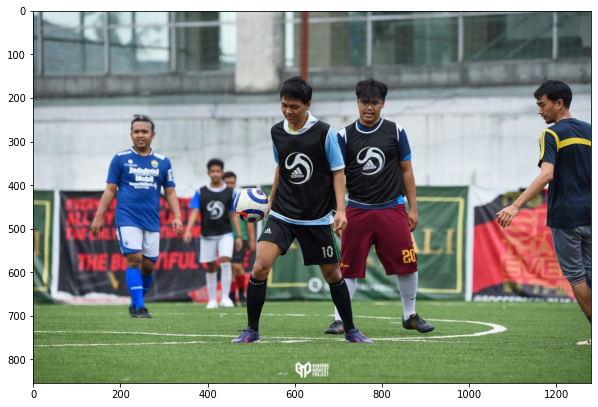

In [8]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

print(image_input.shape) 
print(blob.shape)


(854, 1280, 3)
(1, 3, 416, 416)


(416, 416, 3)


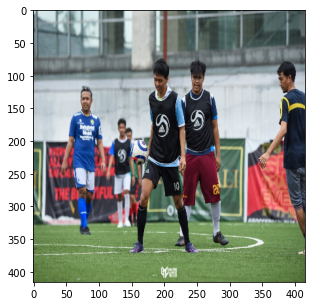

In [10]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [11]:
network.setInput(blob)
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

print('YOLO v3 took {:.5f} seconds'.format(end - start))


YOLO v3 took 4.38772 seconds


In [12]:
print(type(output_from_network))
print(type(output_from_network[0]))

<class 'list'>
<class 'numpy.ndarray'>


In [13]:
np.random.seed(42)
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

print(colours.shape)
print(colours[0])

(80, 3)
[102 220 225]


In [14]:
bounding_boxes = []
confidences = []
class_numbers = []

In [15]:
h, w = image_input_shape[:2]

print(h, w)

854 1280


In [16]:
for result in output_from_network:
      for detection in result:
        scores = detection[5:]
        class_current = np.argmax(scores)

        confidence_current = scores[class_current]

    
        if confidence_current > probability_minimum:
            box_current = detection[0:4] * np.array([w, h, w, h])

            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [17]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])


person
person
person
person
person
person
person
person


In [18]:
if len(results) > 0:
    for i in results.flatten():
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])], confidences[i])

        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

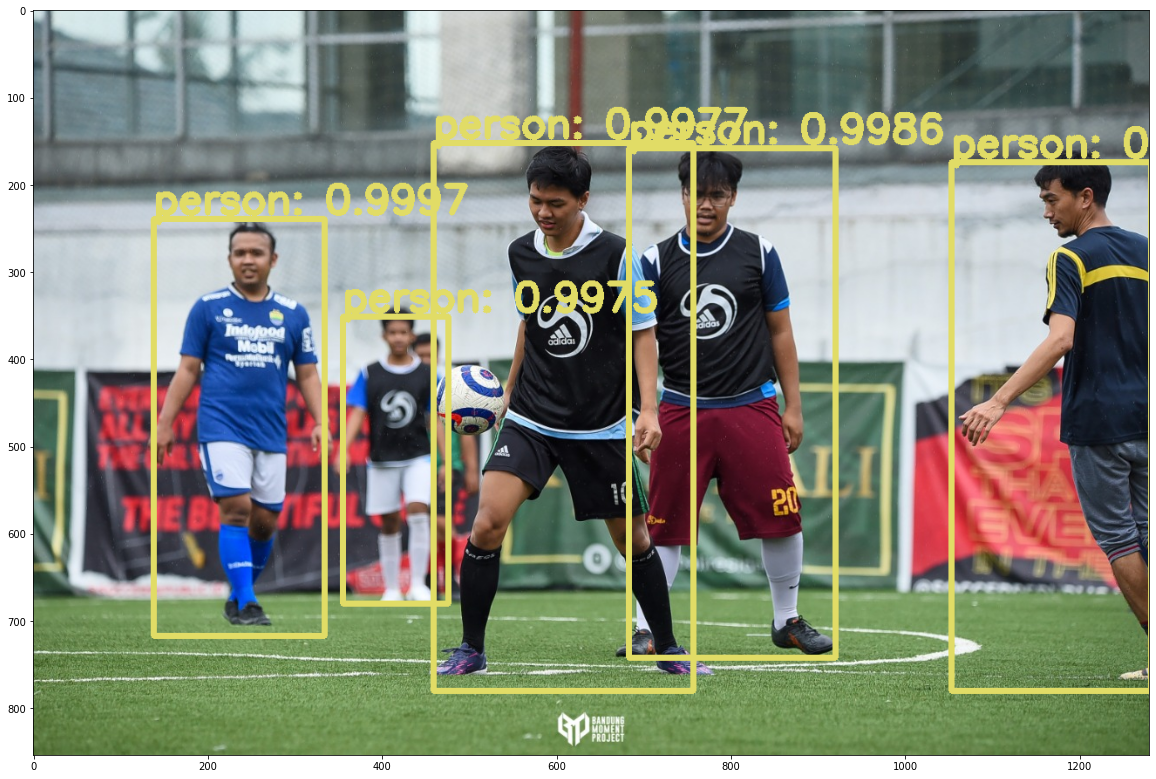

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()
